In [1]:
import os
import time
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [2]:
from sklearn.cluster import SpectralClustering

In [3]:
import visual_behavior_glm.GLM_analysis_tools as gat

In [4]:
import visual_behavior.visualization.utils as utils
import visual_behavior.data_access.loading as loading
import visual_behavior.data_access.utilities as utilities

In [5]:
from visual_behavior.dimensionality_reduction.clustering import processing
from visual_behavior.dimensionality_reduction.clustering import plotting

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


### get experiments and cells tables and limit to closest familiar and novel active

In [7]:
experiments_table = loading.get_platform_paper_experiment_table()
len(experiments_table)

1249

In [8]:
# limit to closest familiar and novel active
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)
len(experiments_table)

402

In [9]:
matched_experiments = experiments_table.index.values

In [10]:
cells_table = loading.get_cell_table()
len(cells_table.cell_specimen_id.unique())

28833

In [11]:
cells_table = loading.get_matched_cells_table(cells_table)
matched_cells = cells_table.cell_specimen_id.unique()

3921 cells in matched cells table


In [12]:
# get cre_lines and cell types for plot labels
cre_lines = np.sort(cells_table.cre_line.unique())
cell_types = utilities.get_cell_types_dict(cre_lines, experiments_table)

### get GLM output, filter and reshape

In [13]:
glm_version = '24_events_all_L2_optimize_by_session'
model_output_type = 'adj_fraction_change_from_full'

In [14]:
base_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4'
base_dir = os.path.join(base_dir, glm_version)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

### NOTE: create a new folder if you are testing out this notebook or else it will overwrite existing files & plots

In [22]:
folder = '220411_cluster_proportions'
save_dir = os.path.join(base_dir, folder)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [23]:
features = processing.get_features_for_clustering()

In [24]:
# get GLM results from saved file in save_dir or from mongo if file doesnt exist
results_pivoted = processing.get_glm_results_pivoted_for_clustering(glm_version, model_output_type, save_dir)
results_pivoted.head()

loading results_pivoted from \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4\24_events_all_L2_optimize_by_session\220411_cluster_proportions\24_events_all_L2_optimize_by_session_results_pivoted.h5


,identifier,Full,all-images,all-omissions,behavioral,hits,image0,image1,image2,image3,...,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,experience_level,passive,image_set,file_id
141,1003771765_1086489847,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,1000740410,VisualBehaviorTask1B,175,VISp,2020-01-29 16:25:58.000000,OPHYS_3_images_B,Familiar,False,B,1003809811
142,1003771765_1086489860,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,1000740410,VisualBehaviorTask1B,175,VISp,2020-01-29 16:25:58.000000,OPHYS_3_images_B,Familiar,False,B,1003809811
143,1003771765_1086489891,0.0,0.000000,-0.524089,-0.376901,0.0,0.000000,0.0,0.0,0.0,...,1000740410,VisualBehaviorTask1B,175,VISp,2020-01-29 16:25:58.000000,OPHYS_3_images_B,Familiar,False,B,1003809811
180,1004403369_1086489847,0.0,-0.310928,0.000000,-0.454319,0.0,-0.158284,0.0,0.0,0.0,...,1000740410,VisualBehaviorTask1B,175,VISp,2020-01-31 16:32:20.000000,OPHYS_4_images_A,Novel 1,False,A,1004465164
181,1004403369_1086489860,0.0,-0.910349,-0.109417,0.000000,0.0,0.000000,0.0,0.0,0.0,...,1000740410,VisualBehaviorTask1B,175,VISp,2020-01-31 16:32:20.000000,OPHYS_4_images_A,Novel 1,False,A,1004465164


In [25]:
# get dropout scores just for the features we want to cluster on
dropouts = processing.limit_results_pivoted_to_features_for_clustering(results_pivoted)
dropouts.head()

,all-images,omissions,behavioral,task,cell_specimen_id,experience_level
141,0.000000,0.000000,0.000000,0.000000,1086489847,Familiar
142,0.000000,0.000000,0.000000,0.000000,1086489860,Familiar
143,0.000000,-0.524089,-0.376901,0.000000,1086489891,Familiar
180,-0.310928,0.000000,-0.454319,-0.009904,1086489847,Novel 1
181,-0.910349,-0.109417,0.000000,0.000000,1086489860,Novel 1


In [70]:
dropouts = processing.flip_sign_of_dropouts(dropouts, processing.get_features_for_clustering())

c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\processing.py:308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [71]:
# unstack dropout scores to get a vector of features x experience levels for each cell
feature_matrix = processing.get_feature_matrix_for_clustering(dropouts, glm_version, save_dir=save_dir)
feature_matrix.head()

No duplicated cells found
3921


all-images                     omissions                     \
experience_level   Familiar   Novel 1  Novel >1  Familiar   Novel 1 Novel >1   
cell_specimen_id                                                               
1086489847         0.000000  0.310928  0.017832  0.000000  0.000000      0.0   
1086489860         0.000000  0.910349  0.000000  0.000000  0.109417      0.0   
1086489891         0.000000  0.677381  0.000000  0.524089  0.000000      0.0   
1086489976         0.817370  0.000000  0.000000  0.000000  0.000000      0.0   
1086490002         0.852927  0.000000  1.000000  0.000000  0.000000      0.0   

                 behavioral                          task                      
experience_level   Familiar   Novel 1  Novel >1  Familiar   Novel 1  Novel >1  
cell_specimen_id                                                               
1086489847         0.000000  0.454319  0.971563  0.000000  0.009904  0.009827  
1086489860         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1086489891         0.376901  0.020819  1.000000  0.000000  0.025777  0.000000  
1086489976         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1086490002         0.000000  0.000000  0.000000  0.021871  0.000000  0.000000

In [72]:
# get cell metadata for all cells in feature_matrix
cell_metadata = processing.get_cell_metadata_for_feature_matrix(feature_matrix, cells_table)
cell_metadata.head()

3921 cells in cell_metadata for feature_matrix


,ophys_experiment_id,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,...,area_binned_depth,layer,date,first_novel,n_relative_to_first_novel,last_familiar,last_familiar_active,second_novel,second_novel_active,experience_exposure
cell_specimen_id,,,,,,,,,,,,,,,,,,,,,
1086551315,794381992,CAM2P.4,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",F,149.0,Slc17a7-IRES2-Cre,GCaMP6f,...,VISp_375,lower,20181212,False,-1.0,True,True,False,False,Familiar 3
1086550804,794381992,CAM2P.4,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",F,149.0,Slc17a7-IRES2-Cre,GCaMP6f,...,VISp_375,lower,20181212,False,-1.0,True,True,False,False,Familiar 3
1086541251,794381992,CAM2P.4,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",F,149.0,Slc17a7-IRES2-Cre,GCaMP6f,...,VISp_375,lower,20181212,False,-1.0,True,True,False,False,Familiar 3
1086540341,794381992,CAM2P.4,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",F,149.0,Slc17a7-IRES2-Cre,GCaMP6f,...,VISp_375,lower,20181212,False,-1.0,True,True,False,False,Familiar 3
1086539950,794381992,CAM2P.4,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",F,149.0,Slc17a7-IRES2-Cre,GCaMP6f,...,VISp_375,lower,20181212,False,-1.0,True,True,False,False,Familiar 3


### plot feature matrix for each cre line

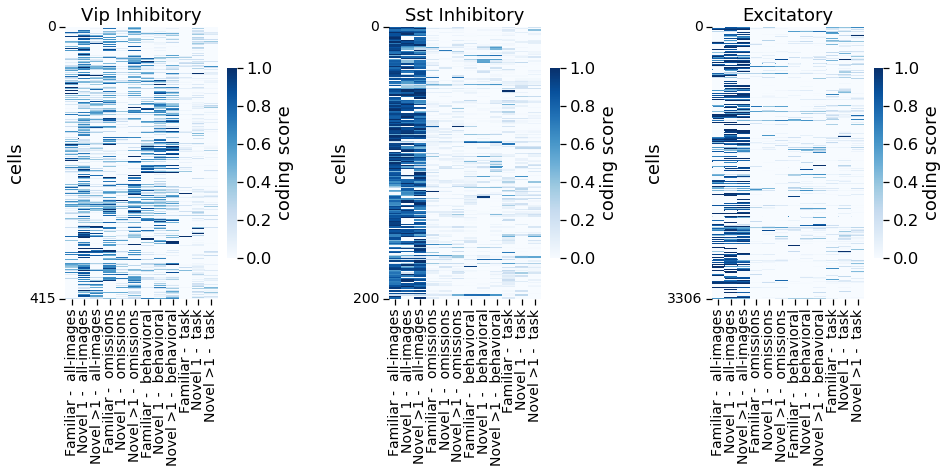

In [73]:
plotting.plot_feature_matrix_for_cre_lines(feature_matrix, cell_metadata, save_dir=base_dir, folder=folder)

### get Silhouette scores

In [29]:
silhouette_scores = processing.load_silhouette_scores(glm_version, feature_matrix, cell_metadata, save_dir)

loading silhouette scores from \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4\24_events_all_L2_optimize_by_session\220411_cluster_proportions\24_events_all_L2_optimize_by_session_silhouette_scores.pkl
done.


### select  number of clusters

In [30]:
n_clusters_cre = {'Slc17a7-IRES2-Cre': 10,
                 'Sst-IRES-Cre': 6, 
                 'Vip-IRES-Cre':12}

### plot silhouettes with selected # clusters

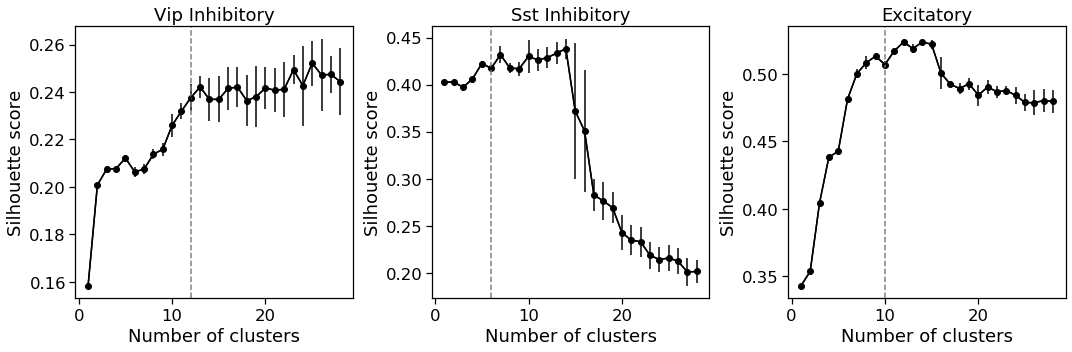

In [31]:
plotting.plot_silhouette_scores_n_clusters(silhouette_scores, cell_metadata, n_clusters_cre=n_clusters_cre, save_dir=base_dir, folder=folder)

### get coclustering matrices per cre line

In [36]:
coclustering_matrices = processing.get_coclustering_matrix(glm_version, feature_matrix, cell_metadata, n_clusters_cre, save_dir, nboot=100)

loading file...
done.


### get cluster labels per cre line from Agglomerative clustering on co-clustering matrix

In [37]:
cluster_labels = processing.get_cluster_labels(coclustering_matrices, cell_metadata, n_clusters_cre, save_dir, load=False)
cluster_labels.head()

generating cluster labels from coclustering matrix
saving cluster_labels to \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4\24_events_all_L2_optimize_by_session\220411_cluster_proportions\cluster_labels_Vip_12_Sst_6_Slc17a7_10.h5


,labels,cell_specimen_id,cre_line,cluster_id
0,5,1086492406,Vip-IRES-Cre,5
1,5,1086492307,Vip-IRES-Cre,5
2,4,1086492221,Vip-IRES-Cre,7
3,5,1086492174,Vip-IRES-Cre,5
4,3,1086491936,Vip-IRES-Cre,1


#### merge cluster labels with cell metadata, remove small clusters, and add manual sort order

In [38]:
cluster_meta = processing.get_cluster_meta(cluster_labels, cell_metadata, feature_matrix, n_clusters_cre, save_dir, load=False)
cluster_meta.head()

generating cluster_meta
dropping 4 cells for ('Slc17a7-IRES2-Cre', 10)
dropping 1 cells for ('Sst-IRES-Cre', 6)
5 cells dropped total
adding within cluster correlation to cluster_meta


C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning:

invalid value encountered in true_divide



saving cluster_meta to \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4\24_events_all_L2_optimize_by_session\220411_cluster_proportions\cluster_metadata_Vip_12_Sst_6_Slc17a7_10.h5


C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:2530: PerformanceWarning:


your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->['equipment_name', 'full_genotype', 'reporter_line', 'driver_line', 'sex', 'cre_line', 'indicator', 'project_code', 'targeted_structure', 'date_of_acquisition', 'session_type', 'experience_level', 'image_set', 'cell_type', 'area_depth', 'area_binned_depth', 'layer', 'experience_exposure', 'manual_sort_order']]




,cluster_id,labels,ophys_experiment_id,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,...,first_novel,n_relative_to_first_novel,last_familiar,last_familiar_active,second_novel,second_novel_active,experience_exposure,original_cluster_id,manual_sort_order,within_cluster_correlation
cell_specimen_id,,,,,,,,,,,,,,,,,,,,,
1086492406,5,5,795073741,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,151.0,...,False,-1.0,True,True,False,False,Familiar 3,5,7,-0.711864
1086492307,5,5,795073741,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,151.0,...,False,-1.0,True,True,False,False,Familiar 3,5,7,-0.948394
1086492221,7,4,795073741,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,151.0,...,False,-1.0,True,True,False,False,Familiar 3,7,3,-0.857523
1086492174,5,5,795073741,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,151.0,...,False,-1.0,True,True,False,False,Familiar 3,5,7,-0.755901
1086491936,1,3,795073741,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,151.0,...,False,-1.0,True,True,False,False,Familiar 3,1,11,0.029602


In [39]:
cluster_meta[['labels', 'cluster_id', 'original_cluster_id', 'manual_sort_order', 'within_cluster_correlation']].head()

,labels,cluster_id,original_cluster_id,manual_sort_order,within_cluster_correlation
cell_specimen_id,,,,,
1086492406,5,5,5,7,-0.711864
1086492307,5,5,5,7,-0.948394
1086492221,4,7,7,3,-0.857523
1086492174,5,5,5,7,-0.755901
1086491936,3,1,1,11,0.029602


### plot co-clustering matrix and dendrograms sorted by linkage matrix

In [40]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [41]:
# for i, cre_line in enumerate(processing.get_cre_lines(cluster_meta)):
#     plotting.plot_coclustering_matrix_and_dendrograms(coclustering_matrices, cre_line, cluster_meta, n_clusters_cre, 
#                                                      save_dir=base_dir, folder=folder)

In [42]:
# data = coclustering_matrices[cre_line]

# fig, ax = plt.subplots(figsize=(8,8))
# ax = sns.clustermap(data=data, cmap='Greys', cbar_kws={'label':'co-clustering probability'})

### sort coclustering matrix by cluster ID / cluster size

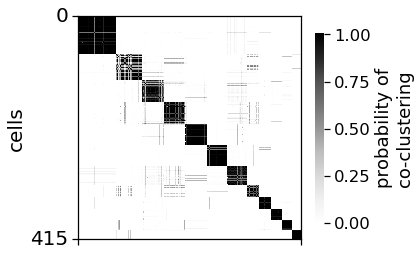

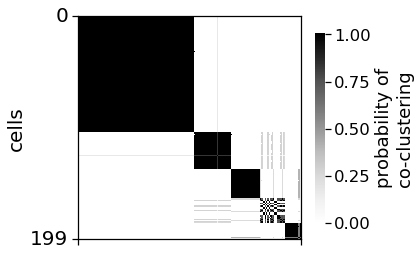

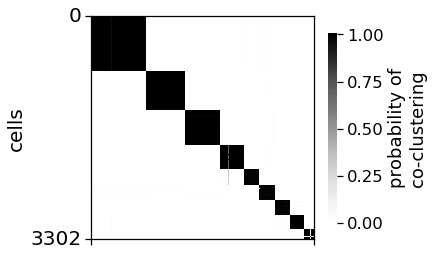

In [43]:
cre_lines = processing.get_cre_lines(cell_metadata)
for cre_line in cre_lines: 
    plotting.plot_coclustering_matrix_sorted_by_cluster_size(coclustering_matrices, cluster_meta, cre_line, 
                                                    save_dir=base_dir, folder=folder, ax=None)

### plot average dropout scores for each cluster

### plot each cluster separately and save to single cell examples dir

In [44]:
cell_examples_dir = os.path.join(save_dir, 'matched_cell_examples')
if not os.path.exists(cell_examples_dir):
    os.mkdir(cell_examples_dir)

In [45]:
# plotting.plot_dropout_heatmaps_and_save_to_cell_examples_folders(cluster_meta, feature_matrix, save_dir)

### plot average dropouts for each cre line in cluster size order

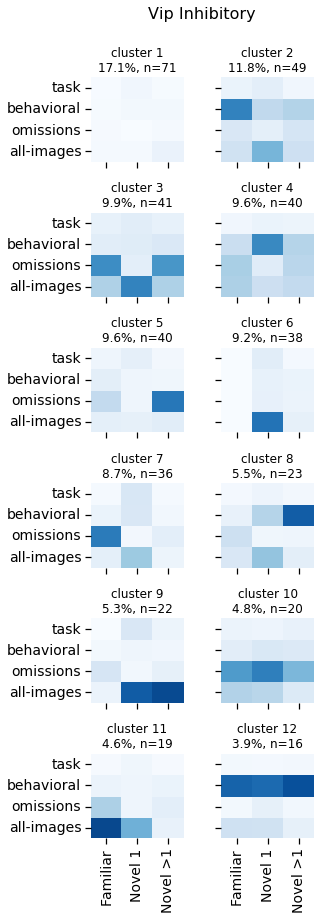

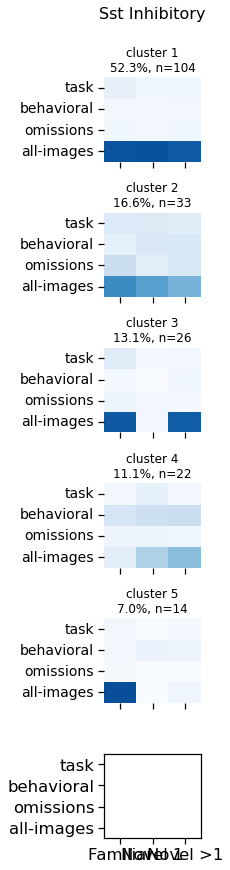

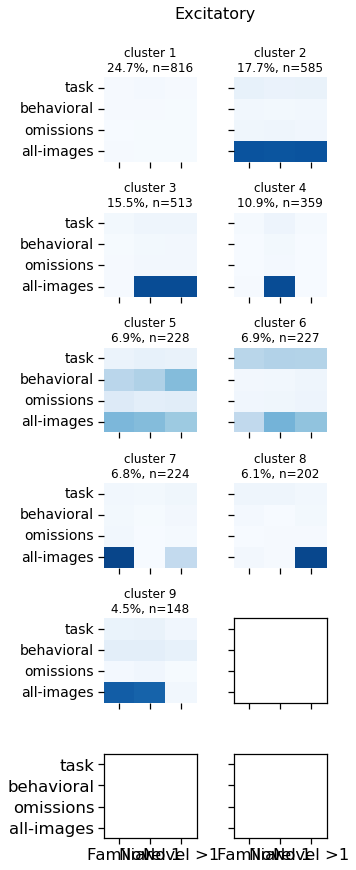

In [74]:
sort_col = 'cluster_id'

plotting.plot_dropout_heatmaps_for_clusters(cluster_meta, feature_matrix, sort_col=sort_col, save_dir=base_dir, folder=folder)

### plot dropout heatmaps in manually sorted order

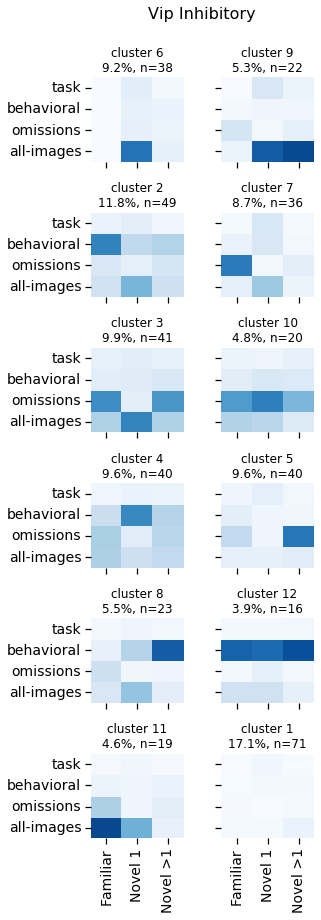

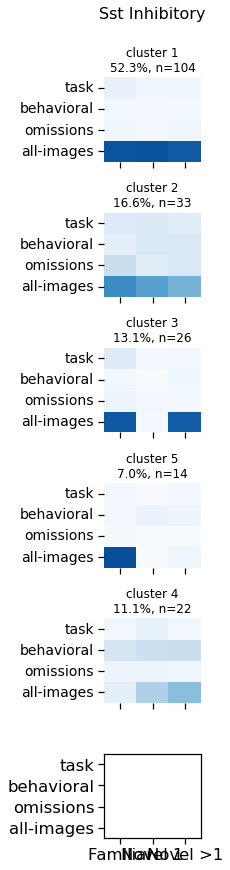

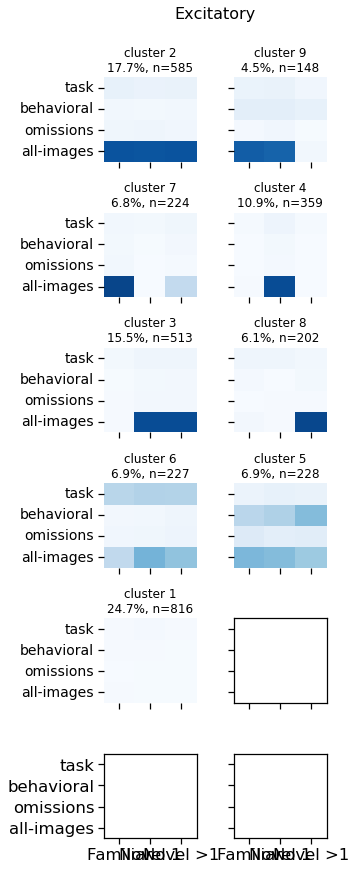

In [75]:
sort_col = 'manual_sort_order'

plotting.plot_dropout_heatmaps_for_clusters(cluster_meta, feature_matrix, sort_col=sort_col, save_dir=base_dir, folder=folder)

### plot feature matrix sorted by cluster ID

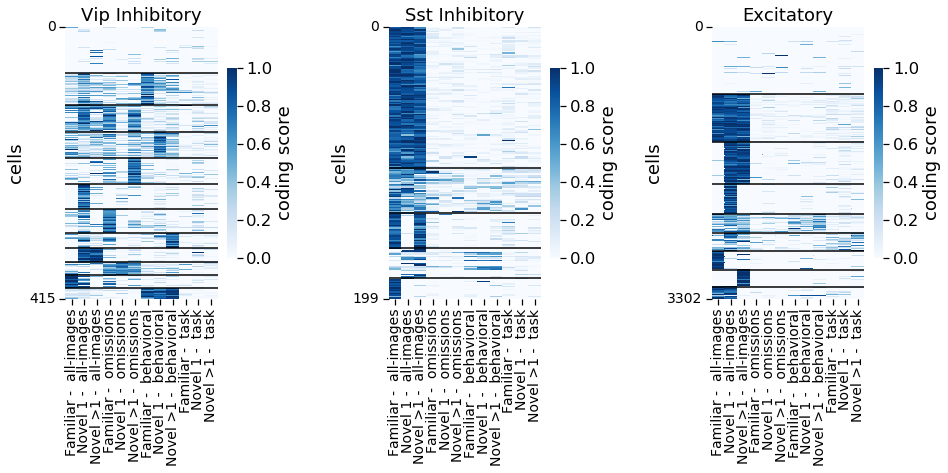

In [76]:
plotting.plot_feature_matrix_sorted(feature_matrix, cluster_meta, sort_col='cluster_id', save_dir=base_dir, folder=folder)
    

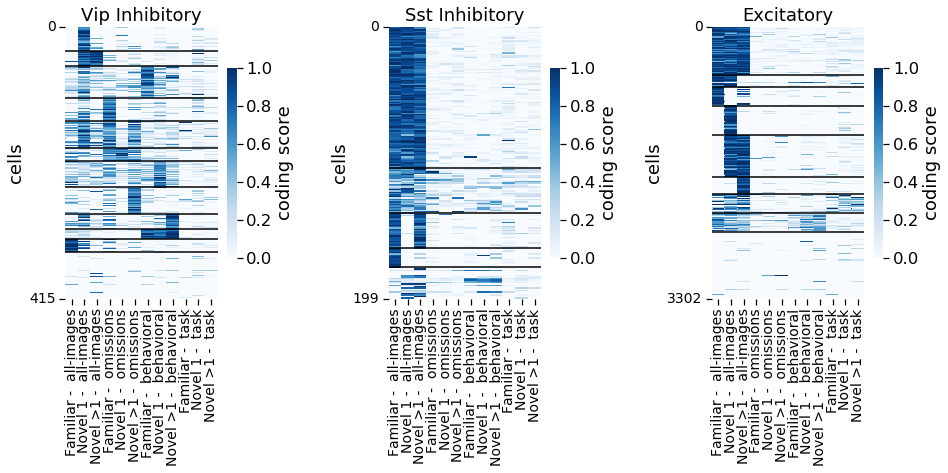

In [77]:
plotting.plot_feature_matrix_sorted(feature_matrix, cluster_meta, sort_col='manual_sort_order', save_dir=base_dir, folder=folder)

### umap with cluster labels

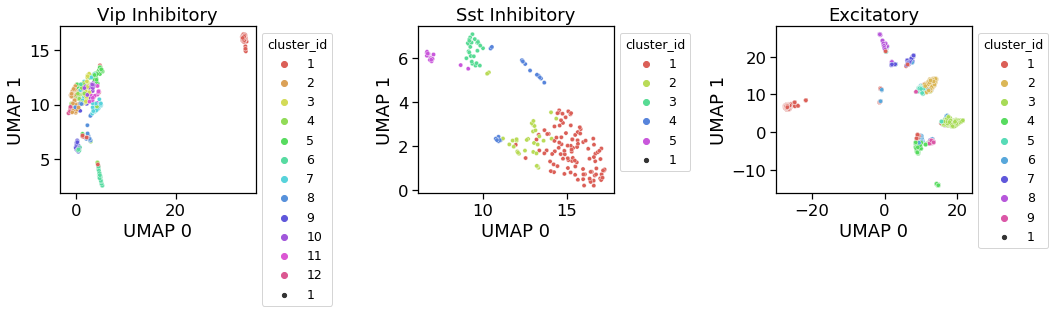

In [50]:
# for column in ['project_code', 'binned_depth', 'targeted_structure', 'mouse_id']:
label_col = 'cluster_id'

plotting.plot_umap_for_clusters(cluster_meta, feature_matrix, label_col=label_col, save_dir=base_dir, folder=folder)


### Correlations within clusters

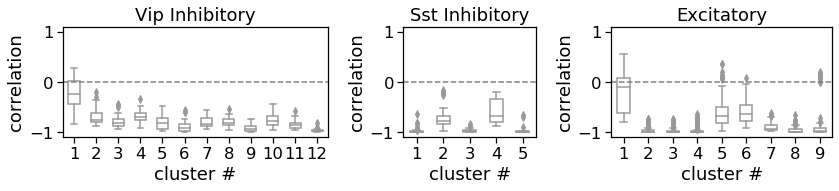

In [51]:
plotting.plot_within_cluster_correlations_all_cre(cluster_meta, n_clusters_cre, sort_order=None, save_dir=base_dir, folder=folder)

### average dropouts per cre line

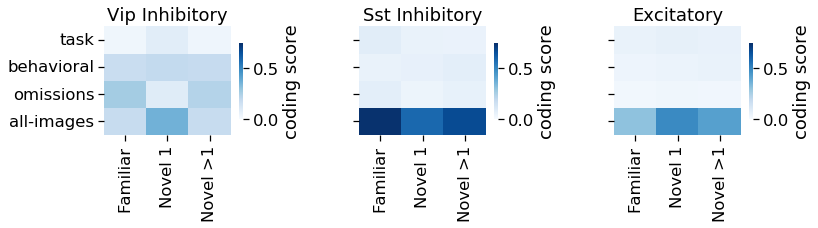

In [78]:
plotting.plot_average_dropout_heatmap_for_cre_lines(dropouts, cluster_meta, save_dir=base_dir, folder=folder)

### plot 100 cells per cluster to examine within cluster variability

In [53]:
# plotting.plot_random_subset_of_cells_per_cluster(cluster_meta, dropouts, save_dir)

### breakdown by area and depth

We are going to normalize within each area or depth to account for the large imbalance in N due to Scientifica datasets only being performed in V1 at certain depths, as well as biological variation in cell type specific expression by depth

### plot fraction cells by area and depth

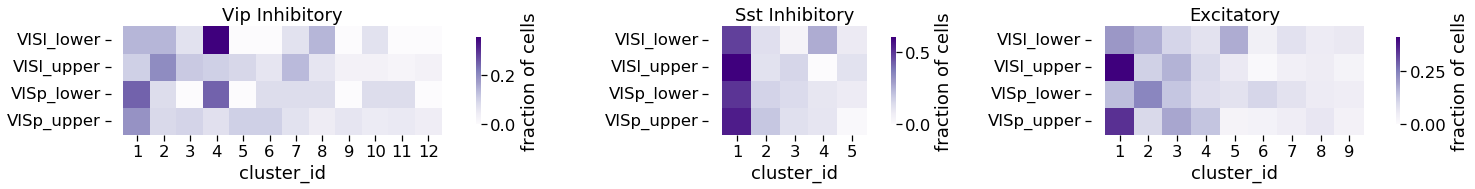

In [54]:
label = 'fraction of cells'
plotting.plot_fraction_cells_by_area_depth(cluster_meta, n_clusters_cre, normalize=True, label=label, 
                                           save_dir=base_dir, folder=folder)

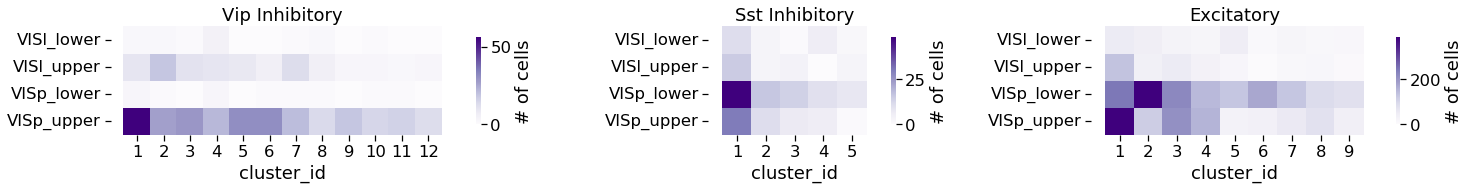

In [55]:
label = '# of cells'
plotting.plot_fraction_cells_by_area_depth(cluster_meta, n_clusters_cre, normalize=False, label=label, 
                                           save_dir=base_dir, folder=folder)

### compute proportion of cells per area / depth relative to cluster average 

In [56]:
# frequency = processing.make_frequency_table(cluster_meta[cluster_meta.cre_line==cre_lines[0]], 
#                                             groupby_columns = ['targeted_structure', 'layer'], normalize=True)
# frequency

In [57]:
# fraction_cells_per_cluster = processing.make_frequency_table(cluster_meta[cluster_meta.cre_line==cre_lines[0]], 
#                                             groupby_columns = ['cre_line'], normalize=True)
# fraction_cells_per_cluster

In [58]:
# # cluster proportions for one cre line
# cluster_proportions_cre = processing.compute_cluster_proportion_cre(cluster_meta, cre_line)
# cluster_proportions_cre

In [59]:
# for all cre lines
proportions = processing.get_proportion_cells_rel_cluster_average(cluster_meta, cre_lines)
proportions

,location,cluster_id,proportion_cells,cre_line
0,VISp_upper,1,0.018327,Vip-IRES-Cre
1,VISp_upper,2,-0.037670,Vip-IRES-Cre
2,VISp_upper,3,0.027175,Vip-IRES-Cre
3,VISp_upper,4,-0.121979,Vip-IRES-Cre
4,VISp_upper,5,0.055397,Vip-IRES-Cre
...,...,...,...,...
31,VISl_lower,5,0.091430,Slc17a7-IRES2-Cre
32,VISl_lower,6,-0.007418,Slc17a7-IRES2-Cre
33,VISl_lower,7,0.018097,Slc17a7-IRES2-Cre
34,VISl_lower,8,-0.002714,Slc17a7-IRES2-Cre


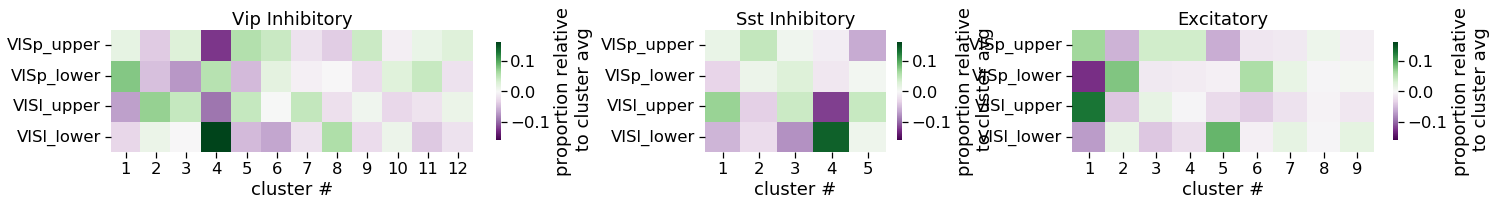

In [79]:
value_to_plot = 'proportion_cells'
cbar_label = 'proportion relative\n to cluster avg'
suffix = '_full_range'

vmax = proportions[value_to_plot].max()

plotting.plot_cell_stats_per_cluster_for_areas_depths(cluster_meta, proportions, n_clusters_cre, 
                                             value_to_plot, cbar_label, cmap='PRGn', vmin=-vmax, vmax=vmax, 
                                             cluster_order=None, save_dir=base_dir, folder=folder, suffix=suffix)

### sort clusters by the fraction of cells in VISp upper using Alexs method

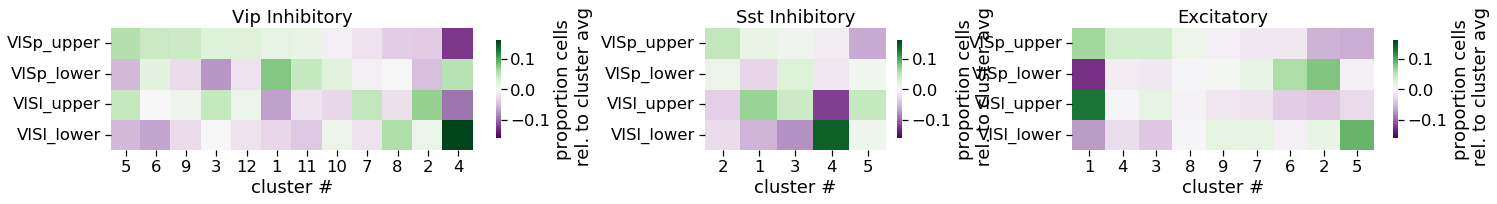

In [80]:
value_to_plot = 'proportion_cells'
cbar_label = 'proportion cells\n rel. to cluster avg'
suffix = '_full_range'

vmax = proportions[value_to_plot].max()

cluster_order = processing.get_cluster_order_for_metric_location(proportions, cluster_meta, 
                                                                 location='VISp_upper', metric='proportion_cells')  

plotting.plot_cell_stats_per_cluster_for_areas_depths(cluster_meta, proportions, n_clusters_cre, 
                                             value_to_plot, cbar_label, cmap='PRGn', vmin=-vmax, vmax=vmax, 
                                             cluster_order=cluster_order, save_dir=base_dir, folder=folder, suffix=suffix)

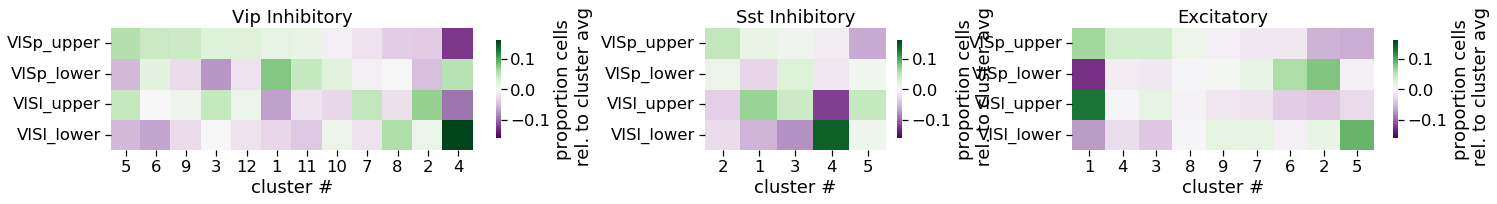

In [81]:
value_to_plot = 'proportion_cells'
cbar_label = 'proportion cells\n rel. to cluster avg'
suffix = '_full_range'

vmax = proportions[value_to_plot].max()

cluster_order = processing.get_cluster_order_for_metric_location(proportions, cluster_meta, 
                                                                 location='VISp_upper', metric='proportion_cells')  

plotting.plot_cell_stats_per_cluster_for_areas_depths(cluster_meta, proportions, n_clusters_cre, 
                                             value_to_plot, cbar_label, cmap='PRGn', vmin=-vmax, vmax=vmax, 
                                             cluster_order=cluster_order, save_dir=base_dir, folder=folder, suffix=suffix)

### get multi session df

In [ ]:
# load dataframe with response traces
df_name = 'omission_response_df'
conditions = ['cell_specimen_id', 'omitted']

data_type = 'events'
event_type = 'omissions'
inclusion_criteria = 'active_only_closest_familiar_and_novel_containers_with_all_levels'


multi_session_df = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria)
print(len(multi_session_df.ophys_experiment_id.unique()))


cluster_mdf = multi_session_df.merge(cluster_meta[['cluster_id']], 
                                     on='cell_specimen_id', how = 'inner')

### alternate ways of plotting cluster proportions

In [92]:
proportions = processing.get_proportion_cells_rel_cluster_average(cluster_meta, cre_lines)


In [96]:
proportions

,location,cluster_id,proportion_cells,cre_line
0,VISp_upper,1,0.018327,Vip-IRES-Cre
1,VISp_upper,2,-0.037670,Vip-IRES-Cre
2,VISp_upper,3,0.027175,Vip-IRES-Cre
3,VISp_upper,4,-0.121979,Vip-IRES-Cre
4,VISp_upper,5,0.055397,Vip-IRES-Cre
...,...,...,...,...
31,VISl_lower,5,0.091430,Slc17a7-IRES2-Cre
32,VISl_lower,6,-0.007418,Slc17a7-IRES2-Cre
33,VISl_lower,7,0.018097,Slc17a7-IRES2-Cre
34,VISl_lower,8,-0.002714,Slc17a7-IRES2-Cre


In [108]:
cre_proportion = proportions[proportions.cre_line==cre_line]

,location,cluster_id,proportion_cells,cre_line


In [116]:
def plot_proportion_cells_for_cluster(cre_proportion, cluster_id, ax=None):
    """
    Plots the proportion of cells in each area and depth for a given cluster
    x values are areas & depths, y values are proportion cells 

    proportion: proportion of cells relative to cluster average per cluster limited to a given cre line
                must include columns: location, proportion_cells, cluster_id, sig_greater
    cluster_id: cluster id to plot
    """
    locations = list(np.sort(cre_counts.location.unique()))

    if ax is None:
        fig, ax = plt.subplots()

    data = cre_counts[cre_counts.cluster_id == cluster_id]
    ax = sns.barplot(data=data, x='location', y='proportion_cells', order=locations, orient='v',
                     palette='Greys', ax=ax)
#     ax.set_ylim(-0.5, 1.5)

#     sig_data = data[data.sig_greater == True]
#     for row in range(len(sig_data)):
#         row_data = sig_data.iloc[row]
#         layer_ind = order.index(row_data.layer)
#         area_ind = hue_order.index(row_data.targeted_structure)
#         if area_ind == 0:
#             y_pos = layer_ind - 0.25
#         elif area_ind == 1:
#             y_pos = layer_ind + 0.25
#         x_pos = row_data.relative_to_random * 1.2
#         ax.plot(x_pos, y_pos, marker='*', color='k')

    ax.legend(fontsize='small', title_fontsize='small')
    ax.set_ylabel('proportion cells', fontsize=14)
    ax.set_xticklabels(locations, fontsize=12, rotation=90)
    ax.set_xlabel('')
    # flip axes so upper layer is on top
    ax.set_xlim(ax.get_xlim()[::-1])
    sns.despine(ax=ax, left=True, bottom=True)
    make fonts small
    ax = standardize_axes_fontsize(ax)
    return ax

No handles with labels found to put in legend.


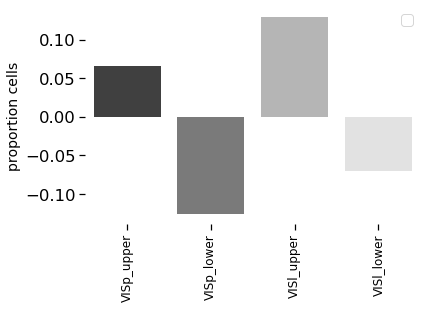

In [117]:
fig, ax = plt.subplots()
plot_proportion_cells_for_cluster(proportions[proportions.cre_line==cre_line], 1, ax=ax)

In [ ]:
# input needed for plot functions
fraction_cells = processing.get_fraction_cells_per_area_depth(cluster_meta)


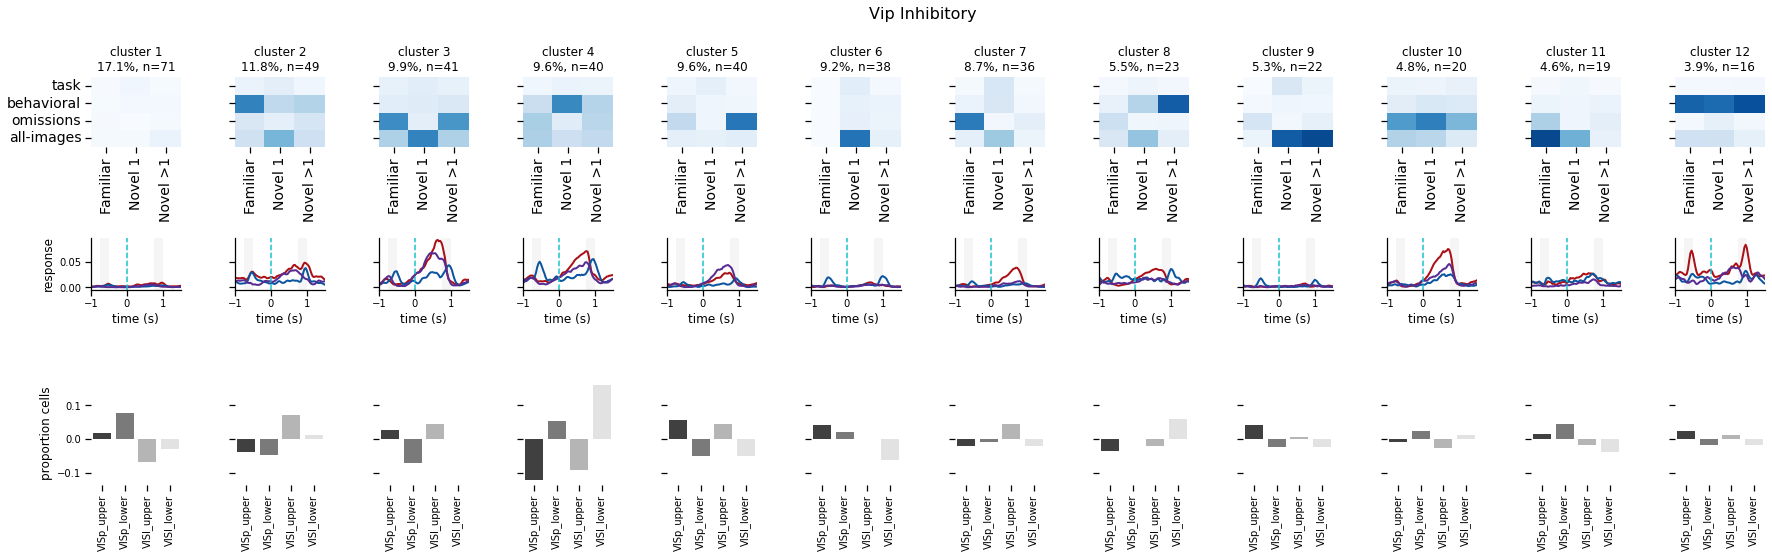

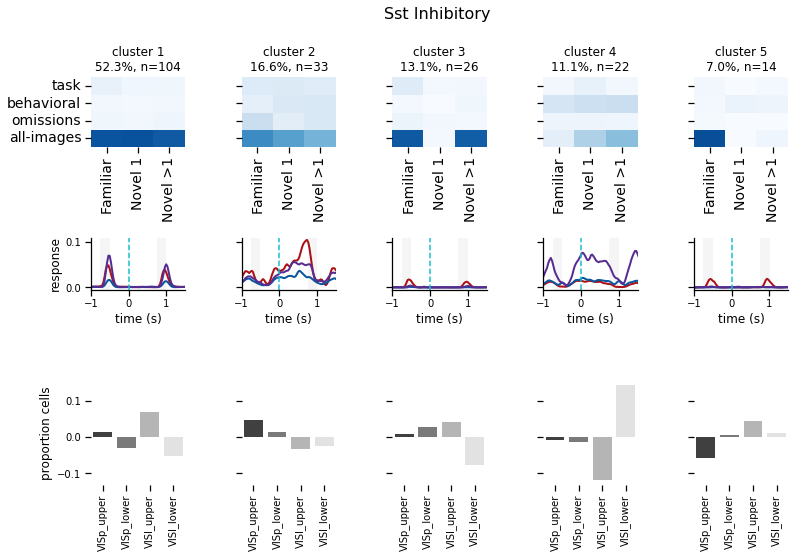

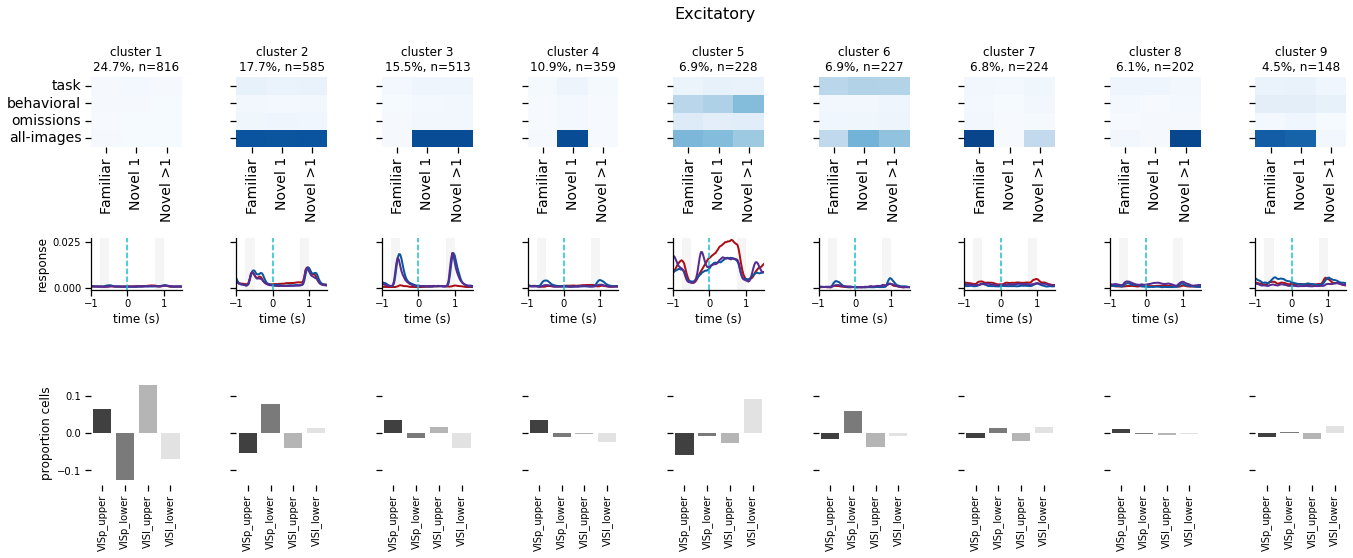

In [125]:

for cre_line in cre_lines:
    plotting.plot_clusters_stats_pop_avg_rows(cluster_meta, feature_matrix, multi_session_df,
                                              proportions, fraction_cells, cre_line,
                                              sort_order=None, suffix='_proportion_rel_avg',
                                              save_dir=base_dir, folder=folder, )



In [ ]:
        # ax[i + (n_clusters * 2)] = plot_pct_rel_to_chance_for_cluster(cre_counts, cluster_id, ax=ax[i + (n_clusters * 2)])
